In [75]:
import geopandas as gpd
import pandas as pd
import yaml
import xarray as xr
import shapely
import os
import matplotlib.pyplot as plt

from data_handler import DataHandler

In [2]:
gpd.options.io_engine = "pyogrio"

In [3]:
# TODO Move to DataHandler
with open('../../config/satvis.yaml', 'r') as f:
    config = yaml.safe_load(f)

dir_dict = config['data_directories']
sub_basin_shp = dir_dict['sub_basin_shp']
cyano_data_shp = dir_dict['cyano_data_shp']

print(sub_basin_shp)
print(cyano_data_shp)

C:\Arbetsmapp\Shapefiler\Sub-basins_Baltic_Sea\Havsomr_SVAR_2016_3b.shp
C:\Arbetsmapp\BAWS\shp_data


# BAWS data

TODO: Move to DataHandler

In [5]:
# def generate_filepaths(directory, pattern='', not_pattern='DUMMY_PATTERN',
#                        pattern_list=[], endswith='',
#                        only_from_dir=True):
#     for path, subdir, fids in os.walk(directory):
#         if only_from_dir:
#             if path != directory:
#                 continue
#         # Generator function (uses yield) https://docs.python.org/3/glossary.html#term-generator
#         for f in fids:
#             if pattern in f and not_pattern not in f and f.endswith(endswith):
#                 if any(pattern_list):
#                     for pat in pattern_list:
#                         if pat in f:
#                             yield os.path.abspath(os.path.join(path, f))
#                 else:
#                     yield os.path.abspath(os.path.join(path, f))

In [29]:
# # TODO Generalize
# # Read files into a list of tables
# for year in range(2002, 2024):
#     year = str(year)
#     geodataframes = []
#     data_files = generate_filepaths(cyano_data_shp, pattern=year, endswith='.shp')
#     for cyano_data_file in data_files:
#         gdf = gpd.read_file(cyano_data_file)
#         # filename = os.path.basename(cyano_data_file)
#         file_ts = pd.Timestamp(os.path.basename(cyano_data_file).split('.')[0].split('_')[-1])
#         # For each table, add new column with timestamp (or original file name if useful)
#         gdf.insert(0, 'date', filename)
#         geodataframes.append(gdf)
#     cyano_shp_dataframe = pd.concat(geodataframes)
#     cyano_shp_dataframe.to_file(f'cyano_daymap_{year}.gpkg')

In [ ]:
# TODO Make the code below duplicate the function of commented code above
data_files = DataHandler.generate_filepaths(cyano_data_shp, pattern=year, endswith='.shp')
DataHandler.cyano_season_geodataframe(data_files)

# Aggregate data

In [4]:
sub_basins = dir_dict['sub_basins']
cyano_data = dir_dict['cyano_data']

In [5]:
# basins = gpd.read_file('../../data/satvistest/dataStructureTest/basins_SVAR_2016.gpkg')
basins = gpd.read_file(sub_basins)

In [6]:
selected_basins = [3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16]
# selected_basins = [9, 10]
boolean_filter = basins['BASIN_NR'].isin(selected_basins)
basins = basins.loc[boolean_filter].set_index('BASIN_NR')
basins

,basin_name,geometry
BASIN_NR,,
3,Bottenhavet,"POLYGON ((620922.743 6729219.402, 620757.133 6..."
4,Ålands hav,"POLYGON ((709486.835 6669336.804, 709413.026 6..."
5,Skärgårdshavet,"POLYGON ((941642.960 6656019.222, 941484.624 6..."
6,Finska viken,"POLYGON ((984634.061 6596697.898, 984670.443 6..."
7,Norra Gotlandshavet,"POLYGON ((693957.780 6565996.762, 693875.447 6..."
8,Västra Gotlandshavet,"POLYGON ((549687.035 6208329.209, 549711.191 6..."
9,Östra Gotlandshavet,"POLYGON ((706381.131 6322005.715, 706379.902 6..."
11,Gdanskbukten,"POLYGON ((876400.422 6233011.174, 876417.638 6..."
12,Bornholmshavet och Hanöbukten,"POLYGON ((449029.888 6137863.106, 449177.826 6..."


In [37]:
gpd.read_file('C:\\Kodning\\Satvis\\data\\satvistest\\dataStructureTest\\cyano_data\\cyano_daymap_2003.gpkg')

,from_file,class,geometry
0,cyano_daymap_20030601.shp,1,"POLYGON ((937261.000 7262123.000, 938261.000 7..."
1,cyano_daymap_20030601.shp,1,"POLYGON ((953261.000 7221123.000, 954261.000 7..."
2,cyano_daymap_20030601.shp,1,"POLYGON ((915261.000 7202123.000, 917261.000 7..."
3,cyano_daymap_20030601.shp,1,"POLYGON ((932261.000 7173123.000, 934261.000 7..."
4,cyano_daymap_20030601.shp,1,"POLYGON ((920261.000 7152123.000, 922261.000 7..."
...,...,...,...
52653,cyano_daymap_20030912.shp,1,"POLYGON ((215261.000 5963123.000, 218261.000 5..."
52654,cyano_daymap_20030912.shp,1,"POLYGON ((887261.000 5955123.000, 888261.000 5..."
52655,cyano_daymap_20030912.shp,1,"POLYGON ((890261.000 5962123.000, 891261.000 5..."
52656,cyano_daymap_20030912.shp,1,"POLYGON ((1252261.000 5958123.000, 1253261.000..."


In [24]:
file_list = []
for file in cyano_data_files:
    file_list.append(file)
file_list

['C:\\Kodning\\Satvis\\data\\satvistest\\dataStructureTest\\cyano_data\\cyano_daymap_2003.gpkg']

In [47]:
cyano_data_files = DataHandler.generate_filepaths(cyano_data, pattern_list=['2003', '2004'])

In [48]:
bloom_list = []

In [49]:
for file in cyano_data_files:
    gdf = gpd.read_file(file)
    bloom_list.append(gdf)
bloom_gdf = pd.concat(bloom_list)

In [50]:
# TODO Move to data_handler
bloom_gdf = bloom_gdf.where(bloom_gdf['class'].isin([2, 3])).dropna()
bloom_gdf.insert(1, 'date', bloom_gdf['from_file'].str.extract(str(r'_(\d{8})\.')))
bloom_gdf['date'] = pd.to_datetime(bloom_gdf['date'])
bloom_gdf = bloom_gdf[['date', 'geometry']]
bloom_gdf = bloom_gdf.groupby('date', as_index=False).apply(lambda x: x.dissolve()).reset_index(drop=True)
# bloom_gdf = bloom_gdf.groupby('date', as_index=False).apply(lambda x: x.dissolve()).set_index('date')

C:\Users\k000851\AppData\Local\Temp\ipykernel_12172\3086183574.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bloom_gdf = bloom_gdf.groupby('date', as_index=False).apply(lambda x: x.dissolve()).reset_index(drop=True)


In [51]:
bloom_gdf

,geometry,date
0,"MULTIPOLYGON (((813261.000 6106123.000, 813261...",2003-07-05
1,"MULTIPOLYGON (((808261.000 6236123.000, 806261...",2003-07-06
2,"MULTIPOLYGON (((877261.000 6427123.000, 877261...",2003-07-07
3,"MULTIPOLYGON (((751261.000 6394123.000, 749261...",2003-07-08
4,"MULTIPOLYGON (((643261.000 6353123.000, 643261...",2003-07-09
...,...,...
82,"MULTIPOLYGON (((628261.000 6310123.000, 628261...",2004-08-14
83,"POLYGON ((654261.000 6397123.000, 663261.000 6...",2004-08-18
84,"POLYGON ((820261.000 6632123.000, 821261.000 6...",2004-08-24
85,"POLYGON ((413261.000 6092123.000, 426261.000 6...",2004-09-04


$\displaystyle a_i$ is equal to the extent that is covered by surface accumulations of cyanobacteria during ($\displaystyle i$) number of days

$\displaystyle A = \frac{\sum a_i \times i}{\sum i} =$ Normalized extent of cyanobacteria bloom

$\displaystyle T = \frac{\sum a_i \times i}{\sum a_i} =$ Normalized duration of cyanobacteria bloom

$\displaystyle I = A \times T =$ Normalized intensity of cyanobacteria bloom

In [34]:
# Cleans the data by removing geometries that don't overlap with the selected basins
# while still retaining dataframe structure
# TODO Better to convert row to dataframe, perform gpd.overlay and turn back into row?
for index, row in day_blooms.iterrows():
    day_bloom_geometry = row.geometry
    intersecting_geometry = day_bloom_geometry.intersection(basins.unary_union)
    
    if not intersecting_geometry.is_empty:
        day_blooms.loc[index, 'geometry'] = intersecting_geometry
    else:
        # Handle the case where there is no intersection (remove the row)
        day_blooms.drop(index, inplace=True)

In [161]:
bloom_gdf['date'].dt.year.unique()

array([2003, 2004])

In [59]:
def area_and_centroid_coords(geom):
        """returns a string of polygon area and centroid coordinates"""
        #For example: 2954918.3 761397.9 7093049.7
        area = round(geom.area, 1)
        centroid = geom.centroid
        x = round(centroid.x, 1)
        y = round(centroid.y, 1)
        value = f"{area} {x} {y}"
        return value

In [55]:
def area_day_count(gdf):
    """Returns a """
    # Create one multiline of all polygon boundaries
    union = shapely.ops.unary_union(gdf.boundary)

    # Polygonize it and create a dataframe
    polygonized = list(shapely.ops.polygonize(union))
    gdf2 = gpd.GeoDataFrame(geometry=polygonized, crs=gdf.crs)

    # Intersect the input gdf with the polygonized gdf. 
    # Duplicate geometries till be created Where multiple polygons overlap
    area_days = gpd.overlay(df1=gdf, df2=gdf2, how="intersection", keep_geom_type=True)

    # Create a unique string to groupby
    area_days["geometry_distinction"] = area_days.apply(
        lambda x: area_and_centroid_coords(x.geometry), axis=1)

    area_days["n_overlaps"] = area_days.groupby("geometry_distinction", 
                                                    as_index=False)["geometry_distinction"].transform("count")
    return area_days

In [162]:
area_days

,date,geometry,geometry_distinction,n_overlaps
0,2004-06-26,"POLYGON ((1140261.000 6723123.000, 1140261.000...",1000000.0 1139761.0 6722623.0,4
1,2004-06-26,"POLYGON ((1141261.000 6723123.000, 1141261.000...",1000000.0 1140761.0 6722623.0,3
2,2004-06-26,"POLYGON ((1142261.000 6722123.000, 1142261.000...",7000000.0 1142903.9 6719765.9,5
3,2004-06-26,"POLYGON ((1144261.000 6722123.000, 1144261.000...",3000000.0 1143427.7 6721289.7,4
4,2004-06-26,"POLYGON ((1147261.000 6721123.000, 1149261.000...",19000000.0 1149024.2 6720307.2,3
...,...,...,...,...
34655,2004-08-24,"POLYGON ((841261.000 6564123.000, 841261.000 6...",7000000.0 842046.7 6565337.3,1
34656,2004-08-24,"POLYGON ((849261.000 6558123.000, 850261.000 6...",35000000.0 846218.1 6560051.6,1
34657,2004-08-24,"POLYGON ((849261.000 6560123.000, 849261.000 6...",3000000.0 849427.7 6561289.7,2
34658,2004-08-24,"POLYGON ((843261.000 6549123.000, 843261.000 6...",1000000.0 843761.0 6549623.0,1


In [167]:
for year in bloom_gdf['date'].dt.year.unique():
    bloom_gdf_season = bloom_gdf.loc[(bloom_gdf['date'] >= f'{year}-06-01') & (bloom_gdf['date'] <= f'{year}-08-31')]
    area_days = area_day_count(bloom_gdf_season)
    area_days.to_file(f'{year}_bloom_day_count_geometries.gpkg')

C:\Users\k000851\AppData\Local\miniforge3\envs\SatvisTest\Lib\site-packages\geopandas\geodataframe.py:1813: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union
C:\Users\k000851\AppData\Local\miniforge3\envs\SatvisTest\Lib\site-packages\geopandas\geodataframe.py:1813: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union


In [166]:
bloom_gdf.loc[(bloom_gdf['date'] >= f'2004-06-01') & (bloom_gdf['date'] <= f'2004-08-31')]

,geometry,date
43,"POLYGON ((1139261.000 6723123.000, 1141261.000...",2004-06-26
44,"MULTIPOLYGON (((650261.000 6440123.000, 650261...",2004-06-29
45,"MULTIPOLYGON (((680261.000 6371123.000, 681261...",2004-06-30
46,"MULTIPOLYGON (((719261.000 6496123.000, 719261...",2004-07-02
47,"MULTIPOLYGON (((725261.000 6303123.000, 724261...",2004-07-05
48,"MULTIPOLYGON (((706261.000 6516123.000, 706261...",2004-07-06
49,"MULTIPOLYGON (((645261.000 6386123.000, 644261...",2004-07-07
50,"MULTIPOLYGON (((688261.000 6202123.000, 688261...",2004-07-08
51,"MULTIPOLYGON (((1169261.000 6685123.000, 11692...",2004-07-09
52,"POLYGON ((976261.000 6636123.000, 979261.000 6...",2004-07-10


In [90]:
for gdf in area_days_gdf_list:
    for year in range(2003, 2005):
        gdf.to_file(f'{year}_bloom_day_count_geometries.gpkg')

<Axes: >

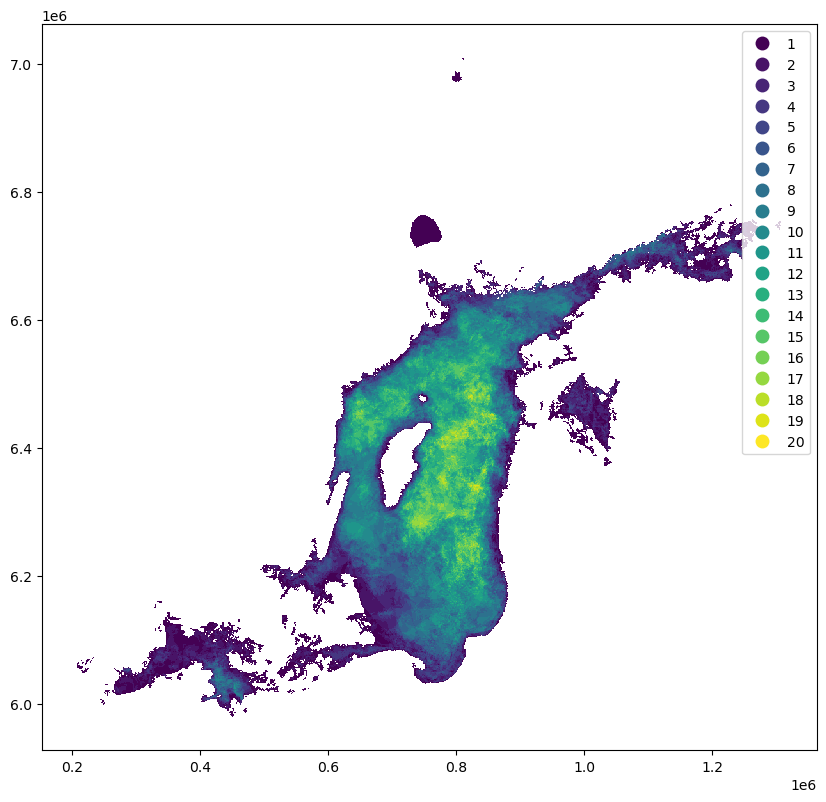

In [72]:
area_days_gdf_list[0].plot(column="n_overlaps", categorical=True, legend=True, cmap="viridis", figsize=(10, 10))

<Axes: >

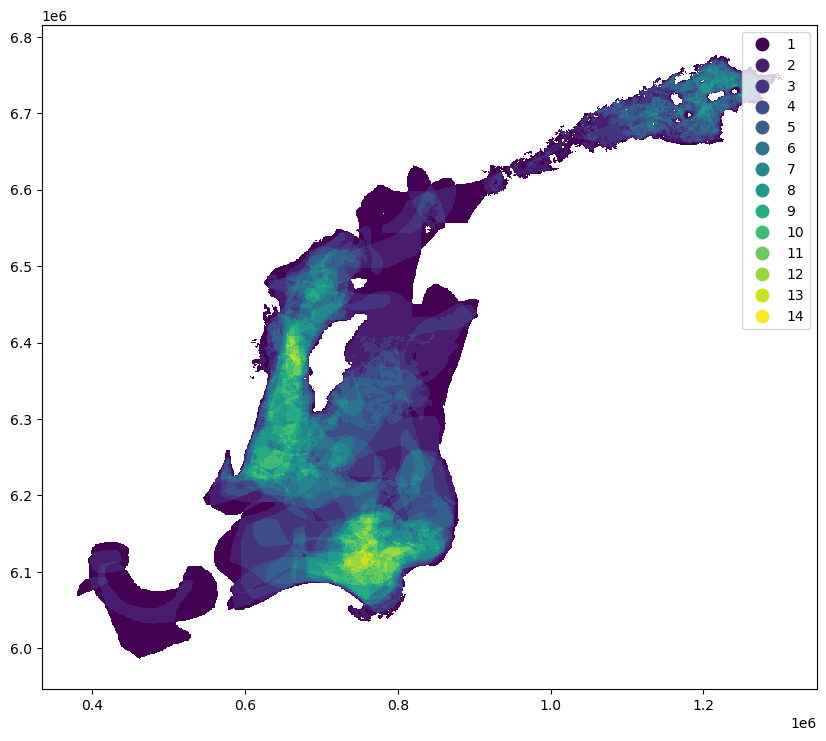

In [73]:
area_days_gdf_list[1].plot(column="n_overlaps", categorical=True, legend=True, cmap="viridis", figsize=(10, 10))


C:\Users\k000851\AppData\Local\miniforge3\envs\SatvisTest\Lib\site-packages\geopandas\geodataframe.py:1813: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union


<Axes: >

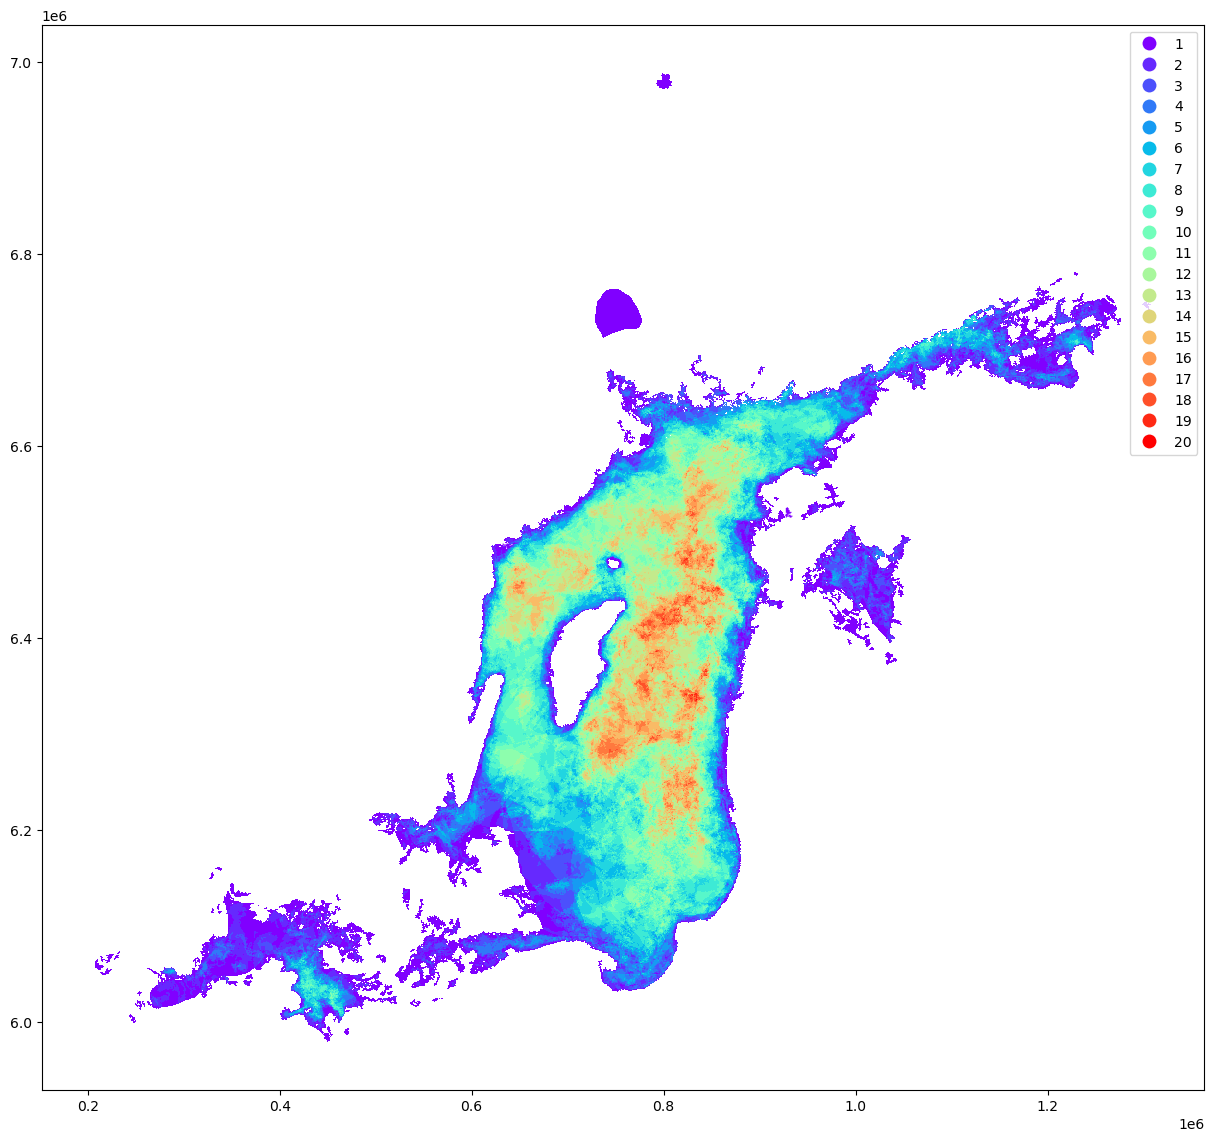

In [42]:
union = shapely.ops.unary_union(day_blooms.boundary) #Create one multiline of all polygon boundaries

#Polygonize it and create a dataframe
polygonized = list(shapely.ops.polygonize(union))
day_blooms2 = gpd.GeoDataFrame(geometry=polygonized, crs=day_blooms.crs)

#Intersect the input df with the polygonized df. 
#Duplicate geometries till be created Where multiple polygons overlap
intersected = gpd.overlay(df1=day_blooms, df2=day_blooms2, how="intersection", keep_geom_type=True)

def area_and_centroid_coords(g):
    """returns a string of polygon area and centroid coordinates"""
    #For example: 2954918.3 761397.9 7093049.7
    area = round(g.area, 1)
    centroid = g.centroid
    x = round(centroid.x, 1)
    y = round(centroid.y, 1)
    value = f"{area} {x} {y}"
    return value

#Create a unique string to groupby
intersected["geometry_distinction"] = intersected.apply(
    lambda x: area_and_centroid_coords(x.geometry), axis=1)

intersected["n_overlaps"] = intersected.groupby("geometry_distinction", 
                                                as_index=False)["geometry_distinction"].transform("count")
intersected.plot(column="n_overlaps", categorical=True, legend=True, cmap="rainbow", figsize=(15, 15))

C:\Users\k000851\AppData\Local\miniforge3\envs\SatvisTest\Lib\site-packages\geopandas\geodataframe.py:1813: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union


<Axes: >

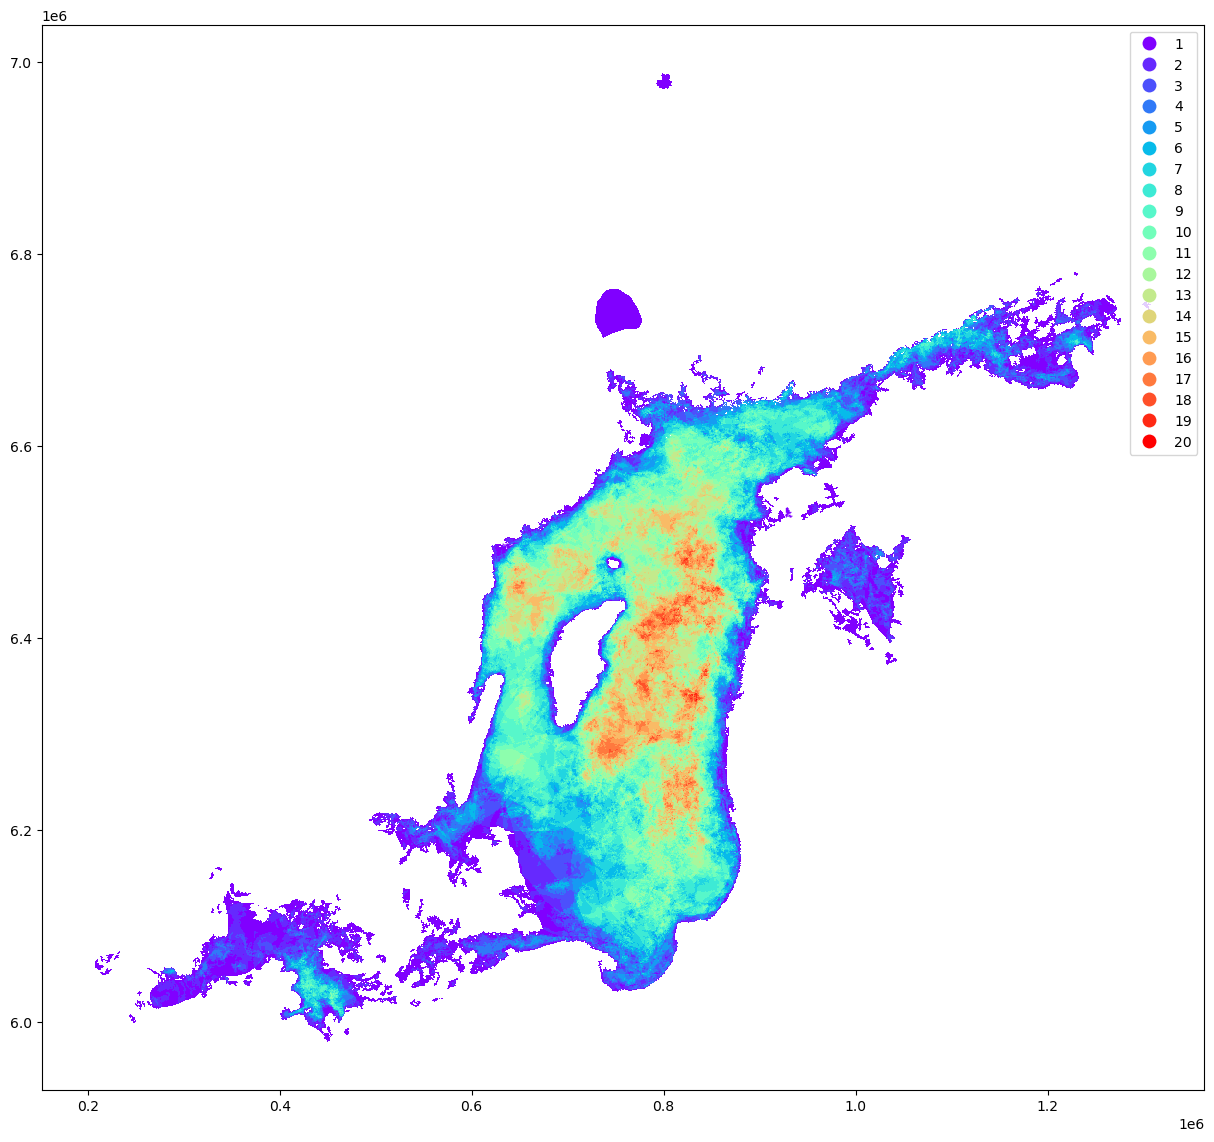

In [157]:
union = shapely.ops.unary_union(day_bloom_season.boundary) #Create one multiline of all polygon boundaries

#Polygonize it and create a dataframe
polygonized = list(shapely.ops.polygonize(union))
day_bloom_season2 = gpd.GeoDataFrame(geometry=polygonized, crs=day_bloom_season.crs)

#Intersect the input df with the polygonized df. 
#Duplicate geometries till be created Where multiple polygons overlap
intersected = gpd.overlay(df1=day_bloom_season, df2=day_bloom_season2, how="intersection", keep_geom_type=True)

def area_and_centroid_coords(g):
    """returns a string of polygon area and centroid coordinates"""
    #For example: 2954918.3 761397.9 7093049.7
    area = round(g.area, 1)
    centroid = g.centroid
    x = round(centroid.x, 1)
    y = round(centroid.y, 1)
    value = f"{area} {x} {y}"
    return value

#Create a unique string to groupby
intersected["geometry_distinction"] = intersected.apply(
    lambda x: area_and_centroid_coords(x.geometry), axis=1)

intersected["n_overlaps"] = intersected.groupby("geometry_distinction", 
                                                as_index=False)["geometry_distinction"].transform("count")
intersected.plot(column="n_overlaps", categorical=True, legend=True, cmap="rainbow", figsize=(15, 15))

$\displaystyle a_i$ is equal to the extent that is covered by surface accumulations of cyanobacteria during ($\displaystyle i$) number of days

$\displaystyle A = \frac{\sum a_i \times i}{\sum i} =$ Normalized extent of cyanobacteria bloom

$\displaystyle T = \frac{\sum a_i \times i}{\sum a_i} =$ Normalized duration of cyanobacteria bloom

$\displaystyle I = A \times T =$ Normalized intensity of cyanobacteria bloom

In [198]:
year_ati = pd.DataFrame()

for year in area_days_gdf['date'].dt.year.unique():
    area_days_year = area_days_gdf.loc[area_days_gdf['date'].dt.year == year]
    a_i = area_days_year.groupby('n_overlaps').apply(lambda x: x.area * x.name).sum()
    year_ati.loc[year, 'A'] = (a_i / len(area_days_year.groupby('date')))
    year_ati.loc[year, 'T'] = (a_i / area_days_year['geometry'].area.sum())
year_ati['I'] = year_ati['A'] * year_ati['T']

C:\Users\k000851\AppData\Local\Temp\ipykernel_12172\1273441532.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  a_i = area_days_year.groupby('n_overlaps').apply(lambda x: x.area * x.name).sum()
C:\Users\k000851\AppData\Local\Temp\ipykernel_12172\1273441532.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  a_i = area_days_year.groupby('n_overlaps').apply(lambda x: x.area * x.name).sum()


In [195]:
year_ati.reset_index(inplace=True)
year_ati.rename(columns={'index': 'year'}, inplace=True)

"Note that the Bothnian Bay, the Gulf of Riga, the Kattegat and the Skagerrak were excluded in the analyses. Also, near shore areas and shallow areas were excluded, see Material and methods for details."

In [199]:
year_ati

,A,T,I
2003,3.367670e+11,10.188812,3.431255e+12
2004,8.648140e+10,5.763881,4.984685e+11


In [202]:
year_ati.to_csv('year_ati.csv', index_label='year')

In [165]:
year_ati_full

,A,T,I
2003,3.290857e+06,10.295976,3.388259e+07
I,NaN,NaN,NaN


In [78]:
type(overlap_area)

pandas.core.series.Series

# Tests

In [ ]:
daygdf = gpd.read_file('data/aggregation_2022.shp')

In [ ]:
daygdf

37

In [ ]:
total_area = daygdf.area.sum() / 1000000.
total_area

245094.0

In [ ]:
area_days = []

In [ ]:
for n in daygdf['class'].unique():
    boolean = daygdf['class'] == n
    area_days.append(daygdf.loc[boolean, :].area.sum() / 1000000. * n)

In [ ]:
boolean = daygdf['class'] == 3
daygdf.loc[boolean, :].area.sum() / 1000000 * 3.

64089.0

In [ ]:
daygdf['class'].unique()

array([ 2,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       19, 18, 20, 21, 22, 23, 25, 24, 26, 27, 28, 29, 30, 31, 33, 32, 35,
       34, 36, 37], dtype=int64)

In [ ]:
boolean = daygdf['class'] == 2

In [ ]:
 area_days

[44884.0,
 26332.0,
 64089.0,
 72188.0,
 75740.0,
 81672.0,
 92106.0,
 103728.0,
 115893.0,
 122950.0,
 123827.0,
 118776.0,
 113100.0,
 107310.0,
 105735.0,
 101840.0,
 92531.0,
 62624.0,
 80946.0,
 51880.0,
 41160.0,
 34210.0,
 29348.0,
 26800.0,
 28056.0,
 24570.0,
 21303.0,
 15344.0,
 9280.0,
 5700.0,
 4495.0,
 858.0,
 2144.0,
 385.0,
 340.0,
 180.0,
 74.0]

In [ ]:
daygdf.loc[boolean, :].area.sum()

30872000000.0

In [ ]:
sum(area_days) / float(total_area)

1.0734599205706847

$\displaystyle a_i$ is equal to the extent that is covered by surface accumulations of cyanobacteria during ($\displaystyle i$) number of days

$\displaystyle A = \frac{\sum a_i \times i}{\sum i} =$ Normalized extent of cyanobacteria bloom

$\displaystyle T = \frac{\sum a_i \times i}{\sum a_i} =$ Normalized duration of cyanobacteria bloom

$\displaystyle I = A \times T =$ Normalized intensity of cyanobacteria bloom

# Basin data
Creates the GeoPackage file 'basins.gpkg' containing SVAR BASIN_NR numeration, geometry and basin_name for the sub-basins of the Baltic Sea according to Havsomr_SVAR_2016_3b

TODO: Move to DataHandler class

In [49]:
# basin_mapping_SVAR = {
#     1: 'Bottenviken',
#     2: 'Norra Kvarken',
#     3: 'Bottenhavet',
#     4: 'Ålands hav',
#     5: 'Skärgårdshavet',
#     6: 'Finska viken',
#     7: 'Norra Gotlandshavet',
#     8: 'Västra Gotlandshavet',
#     9: 'Östra Gotlandshavet',
#     10: 'Rigabukten',
#     11: 'Gdanskbukten',
#     12: 'Bornholmshavet och Hanöbukten',
#     13: 'Arkonahavet och Södra Öresund',
#     14: 'Bälthavet',
#     15: 'Öresund',
#     16: 'Kattegatt',
#     17: 'Skagerrak',
# }

In [65]:
# gdf_basin = gpd.read_file(sub_basin_shp)
# basin_geometries = gdf_basin[['BASIN_NR', 'geometry']]
# basin_data = basin_geometries.dissolve(by='BASIN_NR')
# basin_data['basin_name'] = [basin_mapping_SVAR[item] for item in basin_data.index]

C:\Users\k000851\AppData\Local\miniforge3\envs\SatvisTest\Lib\site-packages\pyogrio\geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)


In [43]:
# basin_data.to_file('basins_SVAR_2016.gpkg')